# IMPORT LIBRARIES

In [1]:
import numpy
import shutil
import pathlib
import matplotlib

import tensorflow
import tensorflow_datasets

import sklearn.metrics
import sklearn.calibration

# CREATE DIRECTORIES

In [2]:
path_results = pathlib.Path("results")

path_model = path_results / "model"
path_dataset = path_results / "dataset"
path_figures = path_results / "figures"

In [3]:
path_results.mkdir()

path_model.mkdir()
path_dataset.mkdir()
path_figures.mkdir()

# CREATE DATASET

In [4]:
(dataset_all, dataset_train, dataset_test), information = tensorflow_datasets.load(
    name="colorectal_histology",
    split=["train", "train[:80%]", "train[80%:]"],
    batch_size=32,
    shuffle_files=True,
    as_supervised=True,
    with_info=True,
)

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

Generating splits...:   0%|          | 0/1 [00:00<?, ? splits/s]

Generating train examples...:   0%|          | 0/5000 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/colorectal_histology/2.0.0.incompleteVIZDVG/colorectal_histology-train.tfr…

Dataset colorectal_histology downloaded and prepared to /root/tensorflow_datasets/colorectal_histology/2.0.0. Subsequent calls will reuse this data.


In [5]:
information

tfds.core.DatasetInfo(
    name='colorectal_histology',
    full_name='colorectal_histology/2.0.0',
    description="""
    Classification of textures in colorectal cancer histology. Each example is a 150 x 150 x 3 RGB image of one of 8 classes.
    """,
    homepage='https://zenodo.org/record/53169#.XGZemKwzbmG',
    data_dir=PosixGPath('/tmp/tmp5ueovabmtfds'),
    file_format=tfrecord,
    download_size=246.14 MiB,
    dataset_size=179.23 MiB,
    features=FeaturesDict({
        'filename': Text(shape=(), dtype=string),
        'image': Image(shape=(150, 150, 3), dtype=uint8),
        'label': ClassLabel(shape=(), dtype=int64, num_classes=8),
    }),
    supervised_keys=('image', 'label'),
    disable_shuffling=False,
    splits={
        'train': <SplitInfo num_examples=5000, num_shards=2>,
    },
    citation="""@article{kather2016multi,
      title={Multi-class texture analysis in colorectal cancer histology},
      author={Kather, Jakob Nikolas and Weis, Cleo-Aron and Bianconi, F

In [6]:
index_width = len(str(information.splits["train"].num_examples))
num_classes = information.features["label"].num_classes
names = information.features["label"].names
names_short = [string[:3] for string in names]

print(f"{index_width=}")
print(f"{num_classes=}")
print(f"{names=}")
print(f"{names_short=}")

index_width=4
num_classes=8
names=['tumor', 'stroma', 'complex', 'lympho', 'debris', 'mucosa', 'adipose', 'empty']
names_short=['tum', 'str', 'com', 'lym', 'deb', 'muc', 'adi', 'emp']


In [7]:
for index, (image, label) in enumerate(dataset_all.unbatch(), start=1):
    tensorflow.keras.utils.array_to_img(image).save(path_dataset / f"{str(index).zfill(index_width)}_{names[label.numpy()]}.png")

# CREATE MODEL

In [8]:
base = tensorflow.keras.applications.InceptionV3(
    include_top=False,
    input_shape=(150, 150, 3),
)

base.trainable = False

base.summary()

87910968/87910968 [==============================] - 1s 0us/step
Model: "inception_v3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 150, 150, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 74, 74, 32)   864         ['input_1[0][0]']                
                                                                                                  
 batch_normalization (BatchNorm  (None, 74, 74, 32)  96          ['conv2d[0][0]']                 
 alization)                                                                                       
                      

In [9]:
classifier = tensorflow.keras.Sequential([
    tensorflow.keras.layers.InputLayer(input_shape=(None, None, 3)),
    tensorflow.keras.layers.Resizing(height=150, width=150),
    tensorflow.keras.layers.Rescaling(scale=1.0/127.5, offset=-1.0),
    base,
    tensorflow.keras.layers.GlobalAveragePooling2D(),
    tensorflow.keras.layers.Dense(units=num_classes, activation="softmax"),
])

classifier.compile(
    optimizer="adam",
    loss="sparse_categorical_crossentropy",
    metrics="sparse_categorical_accuracy",
)

classifier.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resizing (Resizing)         (None, 150, 150, 3)       0         
                                                                 
 rescaling (Rescaling)       (None, 150, 150, 3)       0         
                                                                 
 inception_v3 (Functional)   (None, 3, 3, 2048)        21802784  
                                                                 
 global_average_pooling2d (G  (None, 2048)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dense (Dense)               (None, 8)                 16392     
                                                                 
Total params: 21,819,176
Trainable params: 16,392
Non-trainable params: 21,802,784
_______________________________________

In [10]:
history = classifier.fit(
    x=dataset_train,
    validation_data=dataset_test,
    epochs=100,
    callbacks=tensorflow.keras.callbacks.EarlyStopping(),
)

Epoch 1/100
125/125 [==============================] - 281s 2s/step - loss: 0.9661 - sparse_categorical_accuracy: 0.7035 - val_loss: 0.5521 - val_sparse_categorical_accuracy: 0.8280
Epoch 2/100
125/125 [==============================] - 233s 2s/step - loss: 0.4847 - sparse_categorical_accuracy: 0.8515 - val_loss: 0.4341 - val_sparse_categorical_accuracy: 0.8540
Epoch 3/100
125/125 [==============================] - 268s 2s/step - loss: 0.3639 - sparse_categorical_accuracy: 0.8920 - val_loss: 0.4008 - val_sparse_categorical_accuracy: 0.8720
Epoch 4/100
125/125 [==============================] - 268s 2s/step - loss: 0.2932 - sparse_categorical_accuracy: 0.9125 - val_loss: 0.3907 - val_sparse_categorical_accuracy: 0.8770
Epoch 5/100
125/125 [==============================] - 268s 2s/step - loss: 0.2475 - sparse_categorical_accuracy: 0.9277 - val_loss: 0.3936 - val_sparse_categorical_accuracy: 0.8700


In [11]:
classifier.save(path_model / "classifier.h5")

# CREATE PREDICTIONS

In [12]:
x_all = []
x_train = []
x_test = []

ytn_all = []
ytn_train = []
ytn_test = []


for image, label in dataset_all.unbatch():
    x_all.append(image)
    ytn_all.append(label)

for image, label in dataset_train.unbatch():
    x_train.append(image)
    ytn_train.append(label)

for image, label in dataset_test.unbatch():
    x_test.append(image)
    ytn_test.append(label)


x_all = numpy.array(x_all)
x_train = numpy.array(x_train)
x_test = numpy.array(x_test)

ytn_all = numpy.array(ytn_all)
ytn_train = numpy.array(ytn_train)
ytn_test = numpy.array(ytn_test)

yth_all = numpy.array(tensorflow.one_hot(ytn_all, depth=num_classes))
yth_train = numpy.array(tensorflow.one_hot(ytn_train, depth=num_classes))
yth_test = numpy.array(tensorflow.one_hot(ytn_test, depth=num_classes))

yph_all = classifier.predict(x_all)
yph_train = classifier.predict(x_train)
yph_test = classifier.predict(x_test)

ypn_all = yph_all.argmax(axis=1)
ypn_train = yph_train.argmax(axis=1)
ypn_test = yph_test.argmax(axis=1)

32/32 [==============================] - 45s 1s/step


# CREATE FIGURES

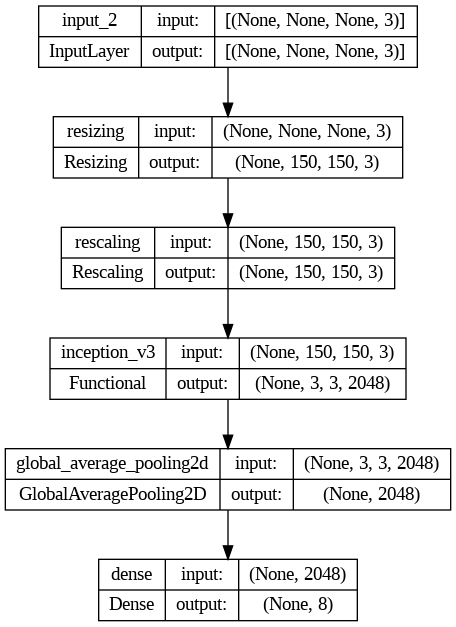

In [13]:
tensorflow.keras.utils.plot_model(
    model=classifier,
    show_shapes=True,
    to_file=path_figures / "classifier.png",
)

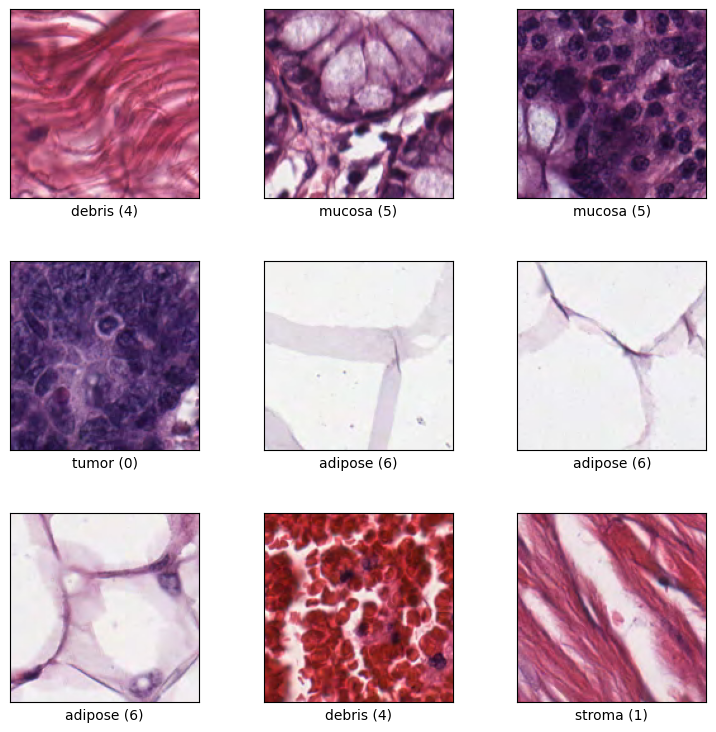

In [14]:
figure = tensorflow_datasets.visualization.show_examples(dataset_all, information, is_batched=True)

figure.savefig(path_figures / "examples.png")

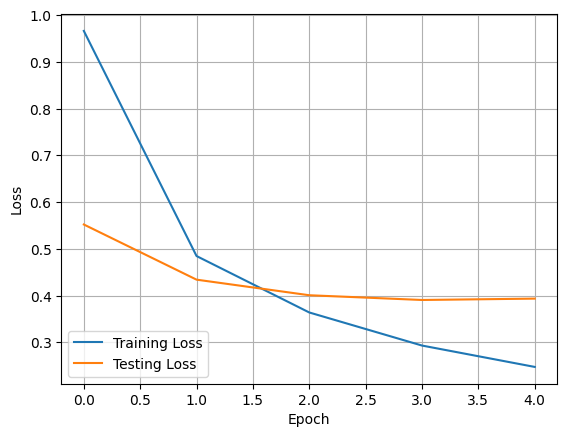

In [15]:
figure, axes = matplotlib.pyplot.subplots()
axes.plot(history.history["loss"], label="Training Loss")
axes.plot(history.history["val_loss"], label="Testing Loss")
axes.legend(loc="lower left")
axes.set_xlabel("Epoch")
axes.set_ylabel("Loss")
axes.grid(True)

figure.savefig(path_figures / "loss.png")

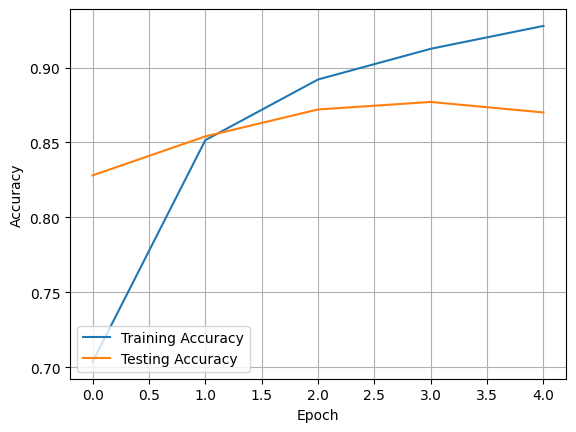

In [16]:
figure, axes = matplotlib.pyplot.subplots()
axes.plot(history.history["sparse_categorical_accuracy"], label="Training Accuracy")
axes.plot(history.history["val_sparse_categorical_accuracy"], label="Testing Accuracy")
axes.legend(loc="lower left")
axes.set_xlabel("Epoch")
axes.set_ylabel("Accuracy")
axes.grid(True)

figure.savefig(path_figures / "accuracy.png")

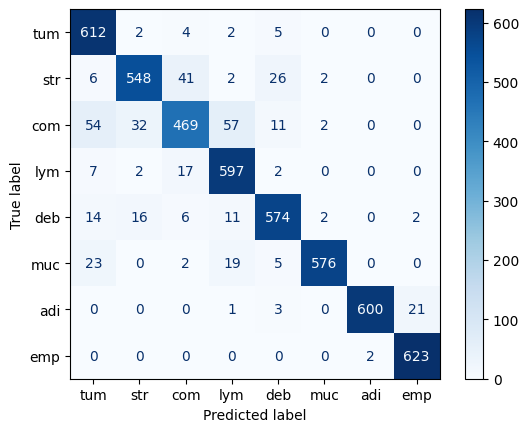

In [17]:
figure, axes = matplotlib.pyplot.subplots()
sklearn.metrics.ConfusionMatrixDisplay.from_predictions(ytn_all, ypn_all, normalize=None, display_labels=names_short, values_format=None, cmap="Blues", ax=axes)

figure.savefig(path_figures / "confusions_all.png")

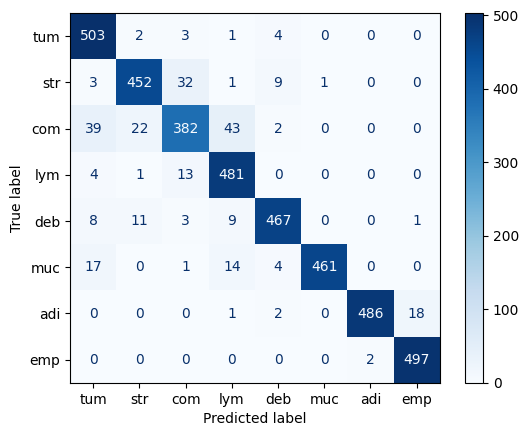

In [18]:
figure, axes = matplotlib.pyplot.subplots()
sklearn.metrics.ConfusionMatrixDisplay.from_predictions(ytn_train, ypn_train, normalize=None, display_labels=names_short, values_format=None, cmap="Blues", ax=axes)

figure.savefig(path_figures / "confusions_train.png")

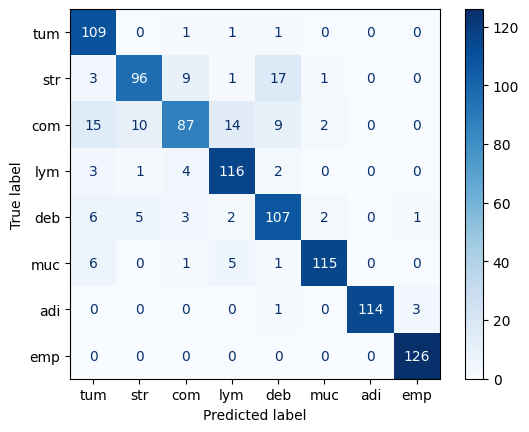

In [19]:
figure, axes = matplotlib.pyplot.subplots()
sklearn.metrics.ConfusionMatrixDisplay.from_predictions(ytn_test, ypn_test, normalize=None, display_labels=names_short, values_format=None, cmap="Blues", ax=axes)

figure.savefig(path_figures / "confusions_test.png")

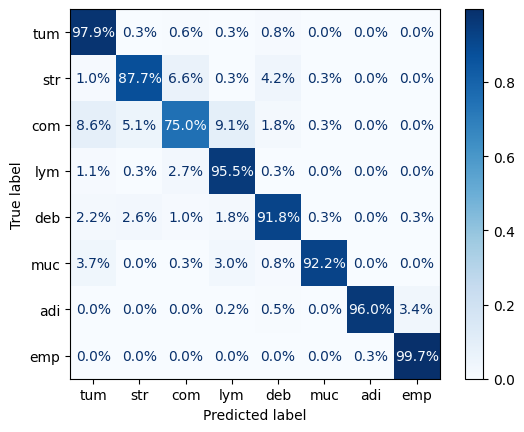

In [20]:
figure, axes = matplotlib.pyplot.subplots()
sklearn.metrics.ConfusionMatrixDisplay.from_predictions(ytn_all, ypn_all, normalize="true", display_labels=names_short, values_format=".1%", cmap="Blues", ax=axes)

figure.savefig(path_figures / "confusionp_all.png")

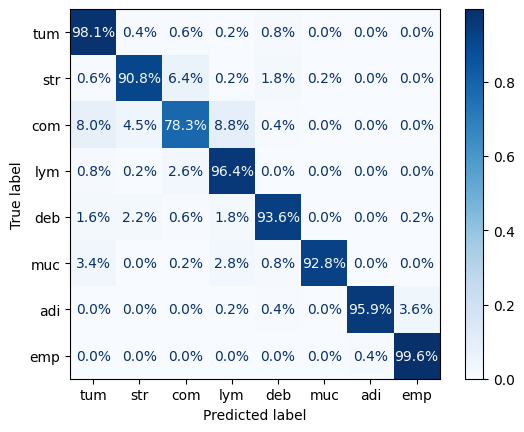

In [21]:
figure, axes = matplotlib.pyplot.subplots()
sklearn.metrics.ConfusionMatrixDisplay.from_predictions(ytn_train, ypn_train, normalize="true", display_labels=names_short, values_format=".1%", cmap="Blues", ax=axes)

figure.savefig(path_figures / "confusionp_train.png")

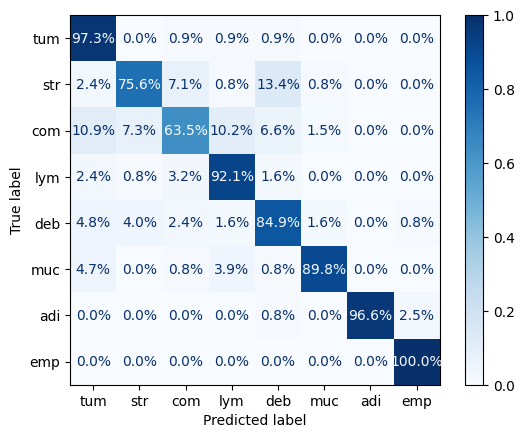

In [22]:
figure, axes = matplotlib.pyplot.subplots()
sklearn.metrics.ConfusionMatrixDisplay.from_predictions(ytn_test, ypn_test, normalize="true", display_labels=names_short, values_format=".1%", cmap="Blues", ax=axes)

figure.savefig(path_figures / "confusionp_test.png")

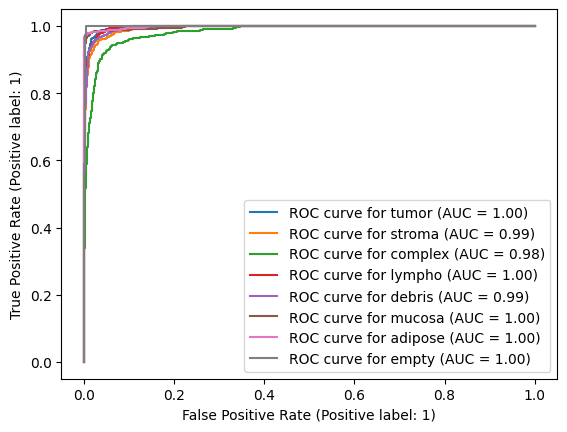

In [23]:
figure, axes = matplotlib.pyplot.subplots()
for label, name in enumerate(names):
    sklearn.metrics.RocCurveDisplay.from_predictions(yth_all[:, label], yph_all[:, label], name=f"ROC curve for {name}", ax=axes)

figure.savefig(path_figures / "roc_all.png")

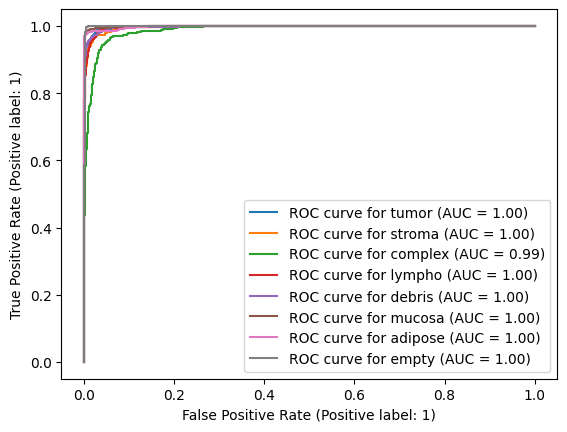

In [24]:
figure, axes = matplotlib.pyplot.subplots()
for label, name in enumerate(names):
    sklearn.metrics.RocCurveDisplay.from_predictions(yth_train[:, label], yph_train[:, label], name=f"ROC curve for {name}", ax=axes)

figure.savefig(path_figures / "roc_train.png")

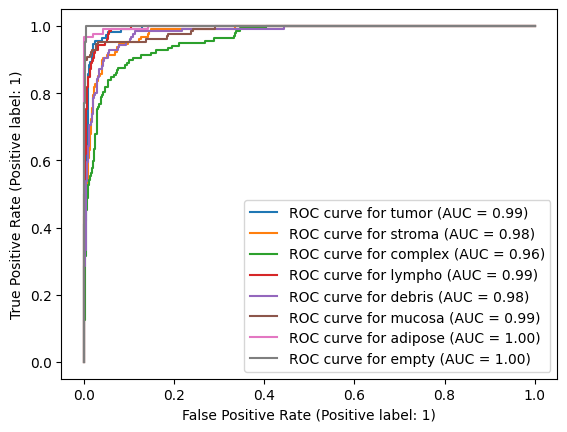

In [25]:
figure, axes = matplotlib.pyplot.subplots()
for label, name in enumerate(names):
    sklearn.metrics.RocCurveDisplay.from_predictions(yth_test[:, label], yph_test[:, label], name=f"ROC curve for {name}", ax=axes)

figure.savefig(path_figures / "roc_test.png")

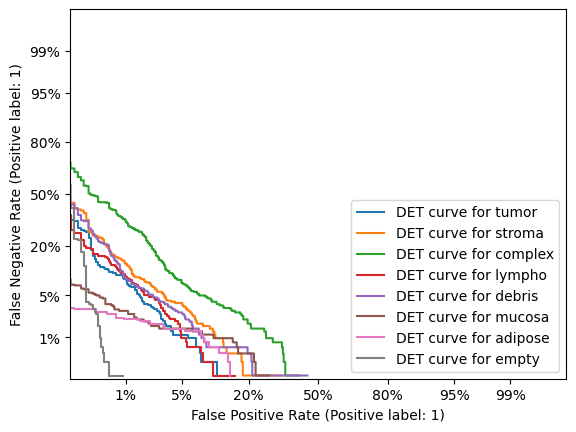

In [26]:
figure, axes = matplotlib.pyplot.subplots()
for label, name in enumerate(names):
    sklearn.metrics.DetCurveDisplay.from_predictions(yth_all[:, label], yph_all[:, label], name=f"DET curve for {name}", ax=axes)

figure.savefig(path_figures / "det_all.png")

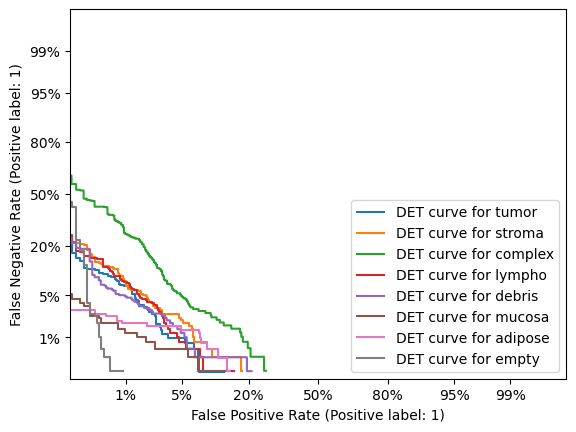

In [27]:
figure, axes = matplotlib.pyplot.subplots()
for label, name in enumerate(names):
    sklearn.metrics.DetCurveDisplay.from_predictions(yth_train[:, label], yph_train[:, label], name=f"DET curve for {name}", ax=axes)

figure.savefig(path_figures / "det_train.png")

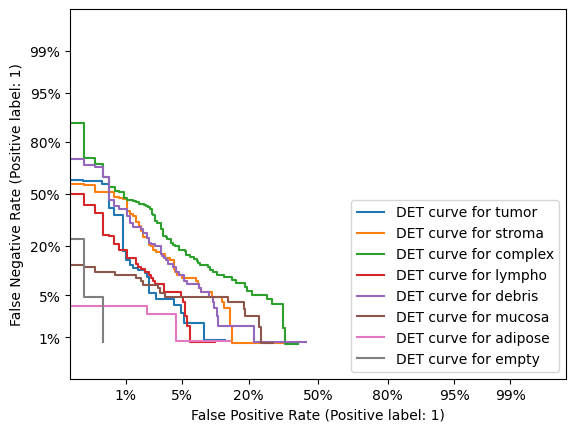

In [28]:
figure, axes = matplotlib.pyplot.subplots()
for label, name in enumerate(names):
    sklearn.metrics.DetCurveDisplay.from_predictions(yth_test[:, label], yph_test[:, label], name=f"DET curve for {name}", ax=axes)

figure.savefig(path_figures / "det_test.png")

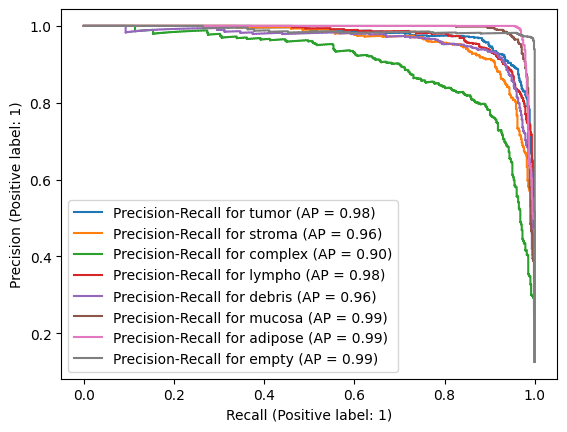

In [29]:
figure, axes = matplotlib.pyplot.subplots()
for label, name in enumerate(names):
    sklearn.metrics.PrecisionRecallDisplay.from_predictions(yth_all[:, label], yph_all[:, label], name=f"Precision-Recall for {name}", ax=axes)

figure.savefig(path_figures / "precisionrecall_all.png")

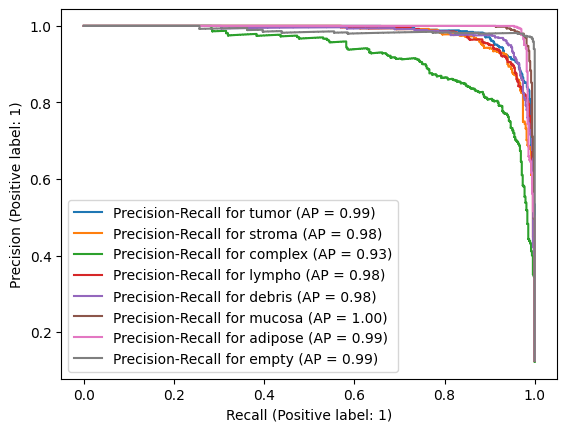

In [30]:
figure, axes = matplotlib.pyplot.subplots()
for label, name in enumerate(names):
    sklearn.metrics.PrecisionRecallDisplay.from_predictions(yth_train[:, label], yph_train[:, label], name=f"Precision-Recall for {name}", ax=axes)

figure.savefig(path_figures / "precisionrecall_train.png")

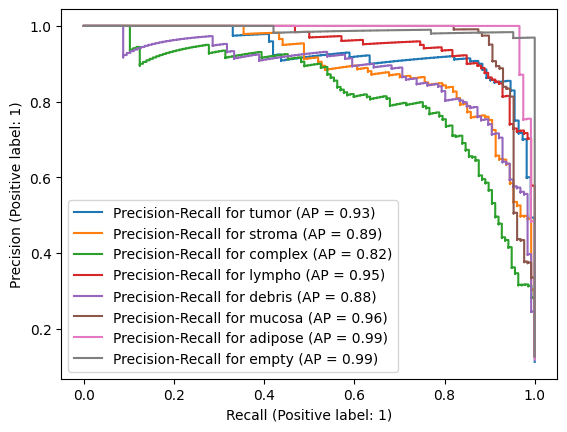

In [31]:
figure, axes = matplotlib.pyplot.subplots()
for label, name in enumerate(names):
    sklearn.metrics.PrecisionRecallDisplay.from_predictions(yth_test[:, label], yph_test[:, label], name=f"Precision-Recall for {name}", ax=axes)

figure.savefig(path_figures / "precisionrecall_test.png")

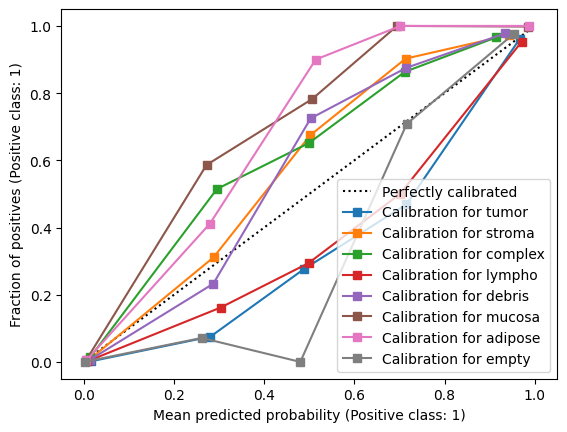

In [32]:
figure, axes = matplotlib.pyplot.subplots()
for label, name in enumerate(names):
    sklearn.calibration.CalibrationDisplay.from_predictions(yth_all[:, label], yph_all[:, label], name=f"Calibration for {name}", ax=axes)

figure.savefig(path_figures / "calibration_all.png")

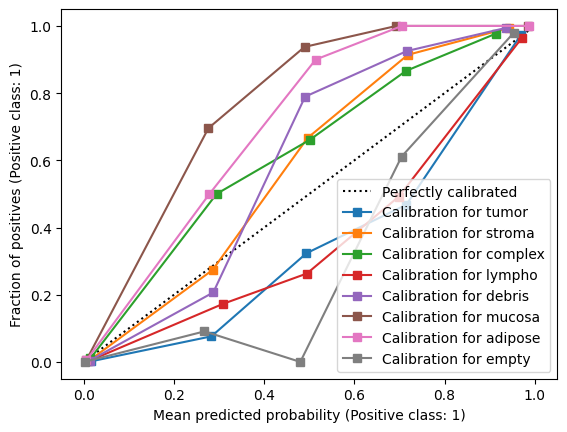

In [33]:
figure, axes = matplotlib.pyplot.subplots()
for label, name in enumerate(names):
    sklearn.calibration.CalibrationDisplay.from_predictions(yth_train[:, label], yph_train[:, label], name=f"Calibration for {name}", ax=axes)

figure.savefig(path_figures / "calibration_train.png")

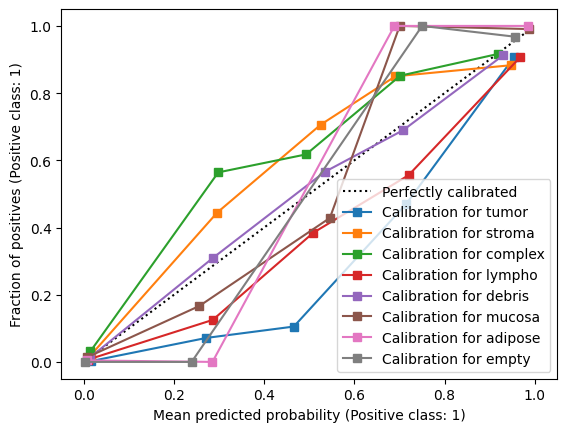

In [34]:
figure, axes = matplotlib.pyplot.subplots()
for label, name in enumerate(names):
    sklearn.calibration.CalibrationDisplay.from_predictions(yth_test[:, label], yph_test[:, label], name=f"Calibration for {name}", ax=axes)

figure.savefig(path_figures / "calibration_test.png")

# COMPRESS RESULTS

In [35]:
shutil.make_archive(
    base_name=path_results,
    format="zip",
    root_dir=path_results,
)

'/content/results.zip'